In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import pof_piv as piv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import trange

In [63]:
# Set parameters
frame_rate = 40000
position = 4
series = 4
window_counts = (25, 8)
margins = (0, 0, 128, 0)

In [59]:
# Read all images in the folder
series_name = 'pos' + str(position) + '-' + str(series)
directory = 'data/' + series_name

images = piv.read_image_directory(directory, image_type='tif', timing=True)
background = cv.imread('data/backgrounds/' + series_name + '.tif', 
                       cv.IMREAD_GRAYSCALE)

In [6]:
# Subtract the background from all images
images = piv.subtract_background(images, background)

In [84]:
# If it does not exist, create a subfolder with the series name in the 'processed' directory
processed_directory = 'processed/' + series_name
if not os.path.exists(processed_directory):
    os.makedirs(processed_directory)

In [ ]:
# Plot average pixel intensity of the cropped images over time
intensity = np.mean(images[:, margins[0]:(images.shape[1] - margins[1]),
             margins[2]:(images.shape[2] - margins[3])], axis=(1, 2))

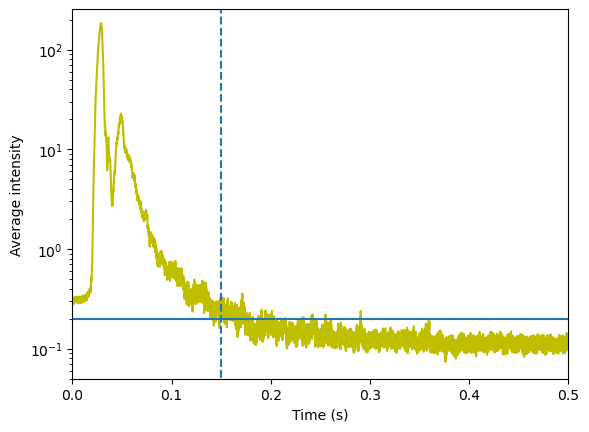

6000.0

In [120]:
fig, ax = plt.subplots()
ax.semilogy(np.arange(len(images))/frame_rate, intensity, color='y')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average intensity')
ax.hlines(0.2, 0, 1)
ax.vlines(0.15, 0, 255, linestyles='--')
ax.set_xlim(0, 0.5)
ax.set_ylim(0.05, 255)
plt.show()

0.15*40000

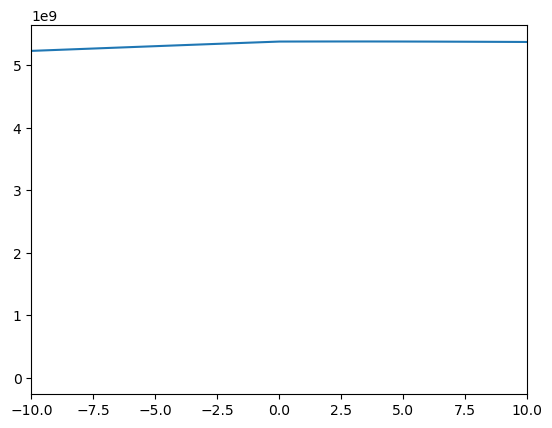

In [144]:
# Calculate the correlation between test frames
test_frame = 1200
correlations_test = piv.correlate_image_pair(images[test_frame, margins[0]:(images.shape[1] - margins[1]),
             margins[2]:(images.shape[2] - margins[3])], images[test_frame + 1, margins[0]:(images.shape[1] - margins[1]),
             margins[2]:(images.shape[2] - margins[3])])

# Plot correlation slice at the middle of the image
fig, ax = plt.subplots()
extent = [-images[0].shape[1] + 0.5, images[0].shape[1] - 0.5,
                     -images[0].shape[0] + 0.5, images[0].shape[0] - 0.5]
ax.plot(np.linspace(-images[0].shape[1], images[0].shape[1], correlations_test.shape[1]), correlations_test[(len(correlations_test)//2-1)])
ax.set_xlim([-10,10])
# ax.set_ylim([8e9, 9e9])

displacements_test = piv.find_displacement(correlations_test) 

In [45]:
# Pre-allocate displacements array
displacements = np.zeros((len(images) - 1, window_counts[0], 2))
centers = np.zeros((len(images) - 1, window_counts[0], 2))

# Loop over all images except the very final one
for i in trange(len(images) - 1):

    # Calculate the PIV between the current and the next image
    displacements[i], centers[i] = piv.horizontal_flow_piv(images[i:i + 2], window_counts, margins=margins)

100%|██████████| 20994/20994 [09:24<00:00, 37.18it/s]


In [46]:
# Save the displacements to a file
np.save(processed_directory + '/displacements1.npy', displacements)

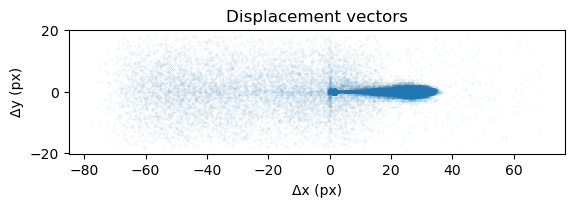

In [121]:
# Plot all displacement vectors as scatter plot
fig, ax = plt.subplots()
ax.scatter(displacements[0:6000, :, 1], displacements[0:6000, :, 0], marker='.', s=0.005)
ax.set_aspect('equal')
ax.set_xlabel('Δx (px)')
ax.set_ylabel('Δy (px)')
ax.set_title('Displacement vectors')
plt.show()

In [60]:
# Load the relevant calibration file
calibration = np.load(f'data/calibration/pos{position}.npy')

/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_95949/3544029544.py:10: RuntimeWarning: Mean of empty slice
  mean_displ[i] = np.nanmean(np.linalg.norm((displacements[i, (displacements[i, :, 0] >= 0), :]), axis=1))


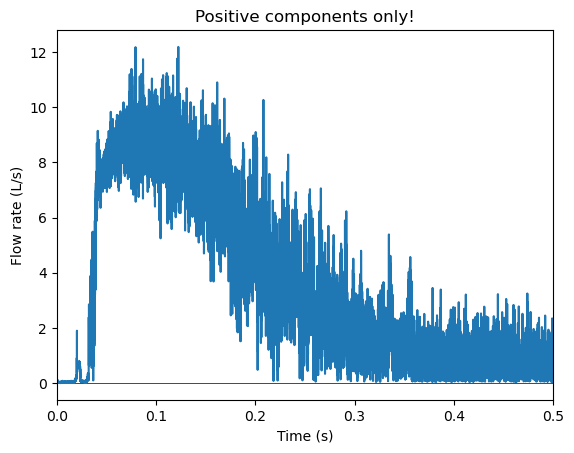

In [99]:
# Load displacement data
displacements = np.load(f'processed/pos{position}-{series}/displacements1.npy')

# Plot the mean displacement magnitude over time
fig, ax = plt.subplots()
ax.hlines(0, -1, 1, color='k', lw=0.5)

mean_displ = np.empty(len(images) - 1)
for i in np.arange(len(images) - 1):
    mean_displ[i] = np.nanmean(np.linalg.norm((displacements[i, (displacements[i, :, 0] >= 0), :]), axis=1))

# mean_displ = np.nanmean(np.linalg.norm(displacements_pos, axis=2), axis=1)
# print(mean_displ.shape)
ax.plot(np.arange(len(images) - 1) / frame_rate, mean_displ/calibration[0]*frame_rate/1000 * 0.01 * 0.02 * 1000)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow rate (L/s)')
ax.set_title('Positive components only!')
ax.set_xlim(0, 0.5)
plt.show()

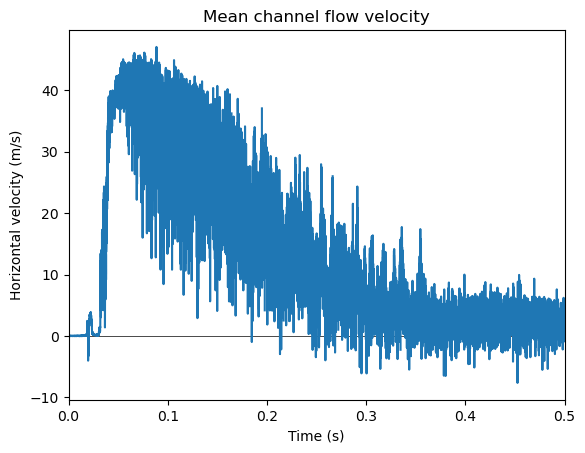

In [82]:
# Plot the mean displacement magnitude over time
fig, ax = plt.subplots()
ax.hlines(0, -1, 1, color='k', lw=0.5)
ax.plot(np.arange(len(images) - 1) / frame_rate, np.mean(displacements[:, :, 1], axis=1)/calibration[0]*frame_rate/1000)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Horizontal velocity (m/s)')
ax.set_title('Mean channel flow velocity')
ax.set_xlim(0, 0.5)
plt.show()

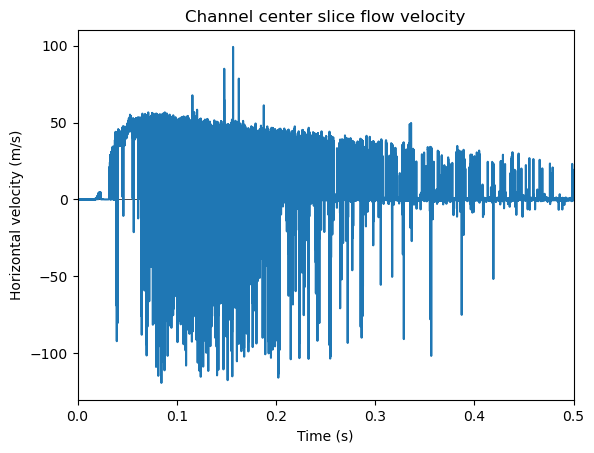

In [83]:
# Plot the mean displacement magnitude over time
fig, ax = plt.subplots()
ax.hlines(0, -1, 1, color='k', lw=0.5)
ax.plot(np.arange(len(images) - 1) / frame_rate, displacements[:, 12, 1]/calibration[0]*frame_rate/1000)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Horizontal velocity (m/s)')
ax.set_title('Channel center slice flow velocity')
ax.set_xlim(0, 0.5)
plt.show()

In [ ]:
# INTENSITY OF LIGHT IN TIME